In [1]:
# -------------------------

# This notebook includes the replication of HASTUS algorithm and sensitivity analysis for different periods

# -------------------------


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import warnings
warnings.simplefilter(action='ignore')
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import zipfile
import geopandas as gpd
from shapely.geometry import Point, LineString
from scipy import stats
import datetime
import matplotlib.dates as mdates
import plotly.graph_objects as go
from matplotlib.ticker import MaxNLocator
import re

In [2]:
season_queries = {
    "2023-1": "service_date >= '2022-12-18' & service_date <= '2023-03-11'",
    "2023-2": "service_date >= '2023-03-12' & service_date <= '2023-07-02'",
    "2023-3": "service_date > '2023-07-02' & service_date <= '2023-08-26'",
    "2023-4"  : "service_date >= '2023-08-27' & service_date <= '2023-12-16'",
    "2024-1": "service_date >= '2023-12-17' & service_date <= '2024-04-06'",
    "2024-2": "service_date >= '2024-04-07' & service_date <= '2024-06-15'",
    "2024-3": "service_date >= '2024-06-16' & service_date <= '2024-08-24'",
    "2024-4"  : "service_date > '2024-08-24' & service_date <= '2024-12-14'",
    "2025-1": "service_date > '2024-12-14' & service_date <= '2025-04-06'",
    "2025-2": "service_date > '2025-04-06' & service_date <= '2025-06-14'",
}

In [3]:
# -------------------------

# Read pre-calculated dataframes from data_process.ipynb
# df_all: cleaned AVL data
# sd_all: trip-level runtimes
# combined: HASTUS schedules between 2023-1 to 2025-3

# -------------------------


df_all = pd.read_csv('df_all.csv')

df_all["service_date"]     = pd.to_datetime(df_all["service_date"],     format="%Y-%m-%d",              errors="coerce")
df_all["scheduled_boston"] = pd.to_datetime(df_all["scheduled_boston"], format="%Y-%m-%d %H:%M:%S",     errors="coerce")
df_all["actual_boston"]    = pd.to_datetime(df_all["actual_boston"],    format="%Y-%m-%d %H:%M:%S",     errors="coerce")

all_available_routes = df_all.drop_duplicates('route_id')
all_available_routes = all_available_routes[all_available_routes['route_id'].astype(str).str.strip().str.fullmatch(r'\d+')]



sd_all = pd.read_csv('sd_all.csv')
sd_all['service_date']    = pd.to_datetime(sd_all['service_date'])


combined = pd.read_csv('combined.csv')


In [4]:
df_all = df_all.rename(columns={'timepointid':'time_point_id'})


In [5]:
# -------------------------

# One digit routes (such as Route 1) are recorded as '01' in database, so we are assigning a 
# route key to avoid integer/string mismatch

# -------------------------

def _route_key(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()

    m = re.fullmatch(r'0*(\d+)([A-Za-z]*)', s)
    if m:
        num = str(int(m.group(1)))          
        suf = m.group(2).upper()            
        return num + suf

    return s.upper()
    
if 'route_key' not in sd_all.columns:
    sd_all = sd_all.copy()
    sd_all['route_key'] = sd_all['route_id'].map(_route_key)

if 'route_key' not in combined.columns:
    combined = combined.copy()
    combined['route_key'] = combined['Route'].map(_route_key)


In [6]:
# -------------------------

# For practicality we are dropping the route names that include a letter (SL1, 34E..)

# -------------------------

combined = combined[combined['Route'].astype(str).str.strip().str.fullmatch(r'\d+')]

In [7]:
# There are some routes that have entries in the schedule but not on in the AVL data after cleaning (714,1013)

combined_28 = combined[combined['Route'].astype(int).isin(sd_all['route_id'].astype(int).unique())]

combined_28['time_dir'] = combined_28['Start'].astype(str)+combined_28['Direction'].astype(str)+ \
         combined_28['rat_id'].astype(str)+combined_28['DOW'].astype(str)+combined_28['type_d'].astype(str)+combined_28['Route'].astype(str)

# There are some routes that have multiple busses running the same schedule (variant?)

cnts = combined_28.value_counts('time_dir').reset_index()
cnts = cnts[cnts['count']==1]
combined_28 = combined_28[combined_28['time_dir'].isin(cnts['time_dir'])]

In [18]:
# -------------------------

# Main block for the HASTUS algorithm replicated with dynamical programming following two rules
# 1: In each profile trip is allowed to be 1 minutes early or 5 minutes late
# 2: In last profile schedule covers 65% of the trips, schedule+lo time covers 90% of the trips

# -------------------------


EARLY = -1.0   # minutes early allowed
LATE  =  5.0   # minutes late  allowed
BIG = 99999999

def hour_to_bin(h):               
    return int(round(h * 2)) % 48

def make_profile_df(win_actual: pd.DataFrame) -> pd.DataFrame:
    df = win_actual.copy().sort_values(['half_trip_id', 'k'])

    df['runtime']  = df.groupby('half_trip_id')['time_diff_x'].cumsum()

    dep_hour = df.groupby('half_trip_id')['hour'].transform('first')
    df['bin'] = dep_hour.apply(hour_to_bin).astype('Int64')   

    return (
        df[['half_trip_id', 'k', 'bin', 'runtime']]
          .rename(columns={'k': 'profile_k'})
    )
    if violations / n > max_viol:
        return BIG, np.nan

    return int(violations), float(S)

# ------------------ A.  ±1 / +5 window  (all non-final profiles) ---------
def block_cost_window(values, start, end, early=EARLY, late=LATE):
    all_vals = np.concatenate(values[start:end + 1])
    n = all_vals.size
    if n == 0:
        return BIG, np.nan 
        
    arr = np.sort(all_vals)
    width = late - early            # 6 min

    left = 0
    best_left = best_right = 0
    for right in range(n):
        while arr[right] - arr[left] > width:
            left += 1
        if right - left > best_right - best_left:
            best_left, best_right = left, right

    t_min, t_max = arr[best_left], arr[best_right]
    S = (t_max - 5 + t_min + 1) / 2
    violations = n - (best_right - best_left + 1)
    return int(violations), float(S)


def block_cost_final(values, start, end, q=0.65):
    all_vals = np.concatenate(values[start:end + 1])
    n = all_vals.size
    if n == 0:
        return BIG, np.nan

    S  = float(np.quantile(all_vals, q))
    late_pts = (all_vals > S).sum()
    
    # enforce at least q coverage in every bin, not just overall
    penalty = 0
    for v in values[start:end + 1]:
        if len(v) == 0:
            continue
        ok = (v <= S).mean()
        if ok < q:                       
            penalty += (q - ok) * len(v) 
    
    return int(late_pts + penalty), S



def build_cost_table(values, min_len=1, *, is_final=False):
    N = 48
    cost  = np.full((N, N), np.inf)
    sched = np.zeros((N, N))

    bc_fn = block_cost_final if is_final else block_cost_window

    for i in range(N):
        for j in range(i + min_len - 1, N):
            cost[i, j], sched[i, j] = bc_fn(values, i, j)
    return cost, sched

def best_segmentation(cost, min_len, min_P, max_P):
    N = cost.shape[0]
    best_total = best_P = None
    best_breaks = None

    for P in range(min_P, max_P + 1):
        if P * min_len > N:
            continue

        opt  = np.full((P + 1, N), np.inf)
        prev = np.full((P + 1, N), -1, dtype=int)

        # first period (p = 1)
        for j in range(min_len - 1, N):
            opt[1, j] = cost[0, j]

        # p = 2 … P
        for p in range(2, P + 1):
            for j in range(p * min_len - 1, N):
                for i in range((p - 1) * min_len - 1, j - min_len + 1):
                    c = opt[p - 1, i] + cost[i + 1, j]
                    if c < opt[p, j]:
                        opt[p, j] = c
                        prev[p, j] = i

        total = opt[P, N - 1]
        if np.isfinite(total) and (best_total is None or total < best_total):
            breaks = []
            j, p = N - 1, P
            while p > 0:
                i = prev[p, j]
                breaks.append((i + 1, j))
                j, p = i, p - 1
            breaks.reverse()

            best_total, best_P, best_breaks = total, P, breaks

    if best_breaks is None:
        raise ValueError("No feasible segmentation under given constraints")
    return best_P, best_breaks

def prep_profile(df_prof):
    counts = np.zeros(48, dtype=int)
    values = [[] for _ in range(48)]

    for _, r in df_prof.iterrows():
        if pd.isna(r['bin']):
            continue                      # skip trips without a departure hour
        b = int(r['bin'])                 
        if 0 <= b < 48:                   # guard against anything weird
            counts[b] += 1
            values[b].append(r['runtime'])

    values = [np.asarray(v, float) for v in values]
    return counts, values

def optimise_profile(df_prof, *, is_final, min_len=1, min_P=3, max_P=10):
    counts, values      = prep_profile(df_prof)
    cost, sched_matrix  = build_cost_table(values, min_len, is_final=is_final)
    best_P, breaks      = best_segmentation(cost, min_len, min_P, max_P)

    profile        = []
    in_spec_total  = 0
    in_spec_L_total = 0                # ← for layover check
    total_pts      = counts.sum()

    for (s, e) in breaks:
        S   = sched_matrix[s, e]
        pts = np.concatenate(values[s:e + 1])

        # ───────── base ±1 / +5 window (non-final) or ≤ S (final) ────────
        if is_final:
            ok_mask = pts <= S                          # earlier/on-time
        else:
            low, high = S + EARLY, S + LATE
            ok_mask = (pts >= low) & (pts <= high)

        ok = ok_mask.sum()
        in_spec_total += ok

        # ───────── extra: per-period layover for the FINAL profile ───────
        if is_final:
            resid = pts - S                            # ≥ 0 ⇒ late
            L     = np.quantile(resid, 0.90)           # 90th 
            L     = max(0, np.ceil(L * 10) / 10)      
            ok_L  = (resid <= L).sum()                 # trips within S+L
            in_spec_L_total += ok_L
            pct_ok_L = round(ok_L / len(pts) * 100, 1)
        else:
            L        = None
            pct_ok_L = None

        profile.append({
            'start_bin' : s,
            'end_bin'   : e,
            'start_t'   : f'{s//2:02d}:{("00","30")[s%2]}',
            'end_t'     : f'{(e+1)//2:02d}:{("00","30")[(e+1)%2]}',
            'sched_run' : round(S, 2),
            'n'         : len(pts),
            'pct_ok'    : round(ok / len(pts) * 100, 1),
            'layover'   : L,            # None except in final profile
            'pct_ok_L'  : pct_ok_L,     
        })

    out = {
        'periods'     : profile,
        'P'           : best_P,
        'pct_ok_all'  : round(in_spec_total / total_pts * 100, 1),
    }

    if is_final:                              
        out['pct_ok_with_L'] = round(in_spec_L_total / total_pts * 100, 1)

    return out


# ------------------------------------------------------------------
# 4.  Run for every profile  (k = 1, 2, 3…)
# ------------------------------------------------------------------
def optimise_all_profiles(win_actual, min_len=1, min_P=3, max_P=8):
    prof_df = make_profile_df(win_actual)
    last_k  = int(prof_df['profile_k'].max())          # e.g. the “1→final” profile
    results = {}

    for k, df_k in prof_df.groupby('profile_k'):
        is_final = (k == last_k)
        results[k] = optimise_profile(
            df_k,
            is_final = is_final,
            min_len  = min_len,
            min_P    = min_P,
            max_P    = max_P,
        )
    return results


In [19]:
def segment_diffs(df, season, time_col):
    """
    Compute per-trip segment runtimes
    """
    out = []
    df = df.copy()
    for k in sorted(df['time_point_order'].unique()):
        end = (df[df['time_point_order'] == k + 1]
               [['half_trip_id', time_col, 'time_point_id', 'route_id', 'direction_id']]
               .rename(columns={time_col: 't_end', 'time_point_id': 'time_point_order_end'}))
        start = (df[df['time_point_order'] == k]
                 [['half_trip_id', time_col, 'hour', 'time_point_id', 'route_id', 'direction_id']]
                 .rename(columns={time_col: 't_start'}))
        merged = start.merge(end, on=['half_trip_id', 'route_id', 'direction_id'], how='inner')
        merged['k'] = k
        merged['time_diff'] = (merged['t_end'] - merged['t_start']).dt.total_seconds() / 60
        out.append(merged[['half_trip_id','route_id','direction_id','k','hour',
                           'time_diff','time_point_id','time_point_order_end']])
    seg = pd.concat(out, ignore_index=True)
    seg['season'] = season
    seg['kind']   = 'actual' if 'actual' in time_col else 'scheduled'
    seg = seg[seg['time_diff'] > 0]
    return seg


# Main block for the schedule thumbs up tool

def compare_schedule_vs_runtime(
    sd_all: pd.DataFrame,
    combined: pd.DataFrame,
    *,
    route: str | int,
    direction: str,          # 'Outbound' / 'Inbound'
    dow: str,                # e.g., 'Weekday'
    schedule_season: str,    # e.g., '2024-4' (single)
    schedule_type: str = 'N',
    schedule_variant: str | None = None,   # if None, uses dominant Variant
    runtime_seasons: tuple[str, ...] = ('2024-3',),  # 1+ seasons
    runtime_type: str = 'N',
    rt_stat: str = 'quantile',   # 'quantile'|'median'|'mean'
    q: float = 0.9,              # used if rt_stat == 'quantile'
    bin_minutes: int = 30,       # hour_Startpoint bin size
    use_top_pair: bool = True,   # keep only most common Start–End pair
    return_frames: bool = False  # also return merged hourly table
):
    """
    Returns dict with deficiency_ratio (positive only part / sum schLO),
    surplus_ratio (negative part / sum schLO), and some counts. Optionally
    also returns the merged hourly comparison table.
    """
    # -------------------------
    # Schedule side (single season)
    # -------------------------
    rk = _route_key(route)
    sch = continuous
    if sch.empty:
        raise ValueError("No schedule rows matched the provided filters.")

    rts = sd_all[
        (sd_all['route_key'] == rk)
        & (sd_all['direction_id'] == direction)
        & (sd_all['season'].isin(runtime_seasons))
        & (sd_all['DOW'] == dow)
    ].copy()

    if rts.empty:
        raise ValueError("No runtime rows matched the provided filters.")

    if use_top_pair:
        # most common Start–End timepoint pair across selected runtime seasons
        pair_counts = (rts.groupby(['timepointid_Startpoint','timepointid_Endpoint'], dropna=False)
                         .size().reset_index(name='count'))
        top_count = pair_counts['count'].max()
        top_pairs = pair_counts.loc[pair_counts['count'] == top_count,
                                    ['timepointid_Startpoint','timepointid_Endpoint']]
        # keep only those trips whose pair is one of the top ones
        rts = rts.merge(top_pairs,
                        on=['timepointid_Startpoint','timepointid_Endpoint'],
                        how='inner')

    # Group runtime to hourly bins with chosen stat
    if rt_stat == 'quantile':
        rtg = (rts.groupby('hour_Startpoint', as_index=False)['actual_run']
                  .quantile(q))
    elif rt_stat == 'median':
        rtg = rts.groupby('hour_Startpoint', as_index=False)['actual_run'].median()
    elif rt_stat == 'mean':
        rtg = rts.groupby('hour_Startpoint', as_index=False)['actual_run'].mean()
    else:
        raise ValueError("rt_stat must be one of {'quantile','median','mean'}.")

    # -------------------------
    # Merge + metrics
    # -------------------------
    comp = sch.merge(rtg, on='hour_Startpoint', how='inner')
    if comp.empty:
        raise ValueError("No overlapping hour bins between schedule and runtime.")

    comp['delta'] = comp['actual_run'] - comp['schLO']
    denom = comp['schLO'].sum()
    if denom == 0 or pd.isna(denom):
        raise ValueError("Sum of schLO is zero/NaN; cannot compute ratios.")

    deficiency_ratio = comp.loc[comp['delta'] > 0, 'delta'].sum() / denom
    surplus_ratio    = comp.loc[comp['delta'] < 0, 'delta'].sum() / denom 

    out = {
        'route': str(route),
        'direction': direction,
        'dow': dow,
        'schedule_season': schedule_season,
        'schedule_type': schedule_type,
        'schedule_variant_used': (schedule_variant
                                  if schedule_variant is not None
                                  else (sch['Variant'].iloc[0] if 'Variant' in sch.columns and len(sch) else None)),
        'runtime_seasons': list(runtime_seasons),
        'runtime_type': runtime_type,
        'rt_stat': rt_stat,
        'q': q if rt_stat == 'quantile' else None,
        'bin_minutes': bin_minutes,
        'use_top_pair': use_top_pair,
        'n_runtime_rows': int(len(rts)),
        'n_overlap_hours': int(len(comp)),
        'deficiency_ratio': float(deficiency_ratio),
        'surplus_ratio': float(surplus_ratio),
    }
    return (out, comp) if return_frames else out


def batch_compare(
    sd_all: pd.DataFrame,
    combined: pd.DataFrame,
    *,
    route: str | int,
    direction: str,
    dow: str,
    schedule_season: str,
    schedule_type: str = 'N',
    schedule_variant: str | None = None,
    runtime_groups: list[tuple[str, tuple[str, ...]]], 
    **kwargs
) -> pd.DataFrame:
    """
    Run multiple runtime bundles against the same schedule season.
    runtime_groups example:
        [
          ("2024-3", ("2024-3",)),
          ("2024-3+2024-2+2024-1", ("2024-3","2024-2","2024-1")),
          ("2022-4+2023-4", ("2022-4","2023-4")),
        ]
    """
    rows = []
    for label, seasons in runtime_groups:
        res = compare_schedule_vs_runtime(
            sd_all, combined,
            route=route, direction=direction, dow=dow,
            schedule_season=schedule_season, schedule_type=schedule_type,
            schedule_variant=schedule_variant,
            runtime_seasons=seasons,
            **kwargs
        )
        res['runtime_label'] = label
        rows.append(res)
    return pd.DataFrame(rows)


In [20]:
def build_mapit(df_all, season_queries, season,
                                    routes, direction, DOW):

    base = df_all.query(season_queries[season]).copy()

    base = base[(base['DOW'] == DOW) &
                (base['direction_id'] == direction) &
                (base['route_id'].isin(routes))].copy()
    
    # Nubn and dudly tags are used for the same stop
    base['time_point_id'] = base['time_point_id'].astype(str).str.replace(
        r'^\s*nubn\s*$', 'dudly', case=False, regex=True
    )
    # compute per-trip segment runtimes
    actual = segment_diffs(base, season, 'actual_boston')
    sched  = segment_diffs(base, season, 'scheduled_boston')

    # match actual vs scheduled (per trip/segment/route)
    mapit = actual.merge(
        sched[['half_trip_id','route_id','direction_id','k','hour','time_diff']],
        on=['half_trip_id','route_id','direction_id','k','hour'],
        how='inner',
        suffixes=('_x','_y')  # -> time_diff_x (actual) & time_diff_y (scheduled)
    )
    mapit['season'] = season
    

    final_cnts = mapit.value_counts(['route_id','time_point_id']).reset_index()
    p = 0.80 
    thr = final_cnts.groupby('route_id')['count'].transform(lambda s: p * s.max())
    final_cnts_filtered = final_cnts[final_cnts['count'] >= thr].copy()
    
    final_cnts_filtered['key'] = final_cnts_filtered['route_id'].astype(str) +'-' +final_cnts_filtered['time_point_id'].astype(str)
    mapit['key'] = mapit['route_id'].astype(str) +'-' +mapit['time_point_id'].astype(str)

    mapit = mapit[mapit['key'].isin(final_cnts_filtered['key'])]
    
    cnts_f = mapit.value_counts('k').reset_index()
    cnts_f = cnts_f[cnts_f['count']>cnts_f['count'].iloc[0]*0.8]
    mapit=mapit[mapit['k'].isin(cnts_f['k'])]

    return mapit


In [11]:
season = '2025-1'
DOW = 'Weekday'
direction = 'Outbound'
routes = ['04']
base = df_all.query(season_queries['2025-1']).copy()

base = base[(base['DOW'] == DOW) &
            (base['direction_id'] == direction) &
            (base['route_id'].isin(routes))].copy()

# Nubn and dudly tags are used for the same stop
base['time_point_id'] = base['time_point_id'].astype(str).str.replace(
    r'^\s*nubn\s*$', 'dudly', case=False, regex=True
)
# compute per-trip segment runtimes
actual = segment_diffs(base, season, 'actual_boston')
sched  = segment_diffs(base, season, 'scheduled_boston')

# match actual vs scheduled (per trip/segment/route)
mapit = actual.merge(
    sched[['half_trip_id','route_id','direction_id','k','hour','time_diff']],
    on=['half_trip_id','route_id','direction_id','k','hour'],
    how='inner',
    suffixes=('_x','_y')  # -> time_diff_x (actual) & time_diff_y (scheduled)
)
mapit['season'] = season


final_cnts = mapit.value_counts(['route_id','time_point_id']).reset_index()
p = 0.80 
thr = final_cnts.groupby('route_id')['count'].transform(lambda s: p * s.max())
final_cnts_filtered = final_cnts[final_cnts['count'] >= thr].copy()

final_cnts_filtered['key'] = final_cnts_filtered['route_id'].astype(str) +'-' +final_cnts_filtered['time_point_id'].astype(str)
mapit['key'] = mapit['route_id'].astype(str) +'-' +mapit['time_point_id'].astype(str)

mapit = mapit[mapit['key'].isin(final_cnts_filtered['key'])]

cnts_f = mapit.value_counts('k').reset_index()
cnts_f = cnts_f[cnts_f['count']>cnts_f['count'].iloc[0]*0.8]
mapit=mapit[mapit['k'].isin(cnts_f['k'])]

In [21]:
def build_profile_tables(mapit: pd.DataFrame, prof_res: dict):

    df = (mapit.copy()
          .sort_values(['half_trip_id', 'k'])
          .assign(runtime=lambda d: d.groupby('half_trip_id')['time_diff_x'].cumsum()))

    dep_hour = df.groupby('half_trip_id')['hour'].transform('first')
    bin_ = ((dep_hour * 2).round().astype('int') % 48).astype('Int64')

    df = (df.assign(bin=bin_)
            [['half_trip_id', 'k', 'bin', 'runtime']]
            .rename(columns={'k': 'profile_k'}))
    df['hour'] = df['bin'] / 2

    ka = int(df['profile_k'].max())

    # --- periods -> continuous half-hour blocks ---
    opt = pd.DataFrame(prof_res[ka]['periods']).copy()
    opt['start_time'] = opt['start_bin'] / 2
    opt['end_time']   = (opt['end_bin'] + 1) / 2

    opt['hour_blocks'] = opt.apply(
        lambda r: np.arange(r['start_time'], r['end_time'], 0.5), axis=1
    )
    opt['schedLO'] = opt['sched_run'] + opt['layover']

    continuous = (opt.explode('hour_blocks', ignore_index=True)
                    [['hour_blocks', 'sched_run', 'schedLO']]
                    .rename(columns={'hour_blocks': 'hour'})
                    .sort_values('hour', kind='mergesort')
                    .reset_index(drop=True))

    df2 = (df.loc[df['profile_k'] == ka]
             .merge(continuous, on='hour', how='left'))

    continuous_renamed = continuous.rename(
        columns={'hour': 'hour_Startpoint', 'schedLO': 'schLO'}
    )

    return df2, continuous_renamed,opt

In [12]:
all_routes = list(all_available_routes['route_id'])

In [130]:
hds = ['01', '07', '09', '101', '109', '11',
       '111', '116', '15', '16', '21', '216', '22', '23', '28',
       '31', '32', '34', '36', '37', '39', '57', '65', '66', '71', '73',
       '77', '86', '104', '17', '44', '504', '69', '70',
       '89', '225', '42', '47', '442', '110', '45', '83', '64',
       '240', '78', '88', '501', '411', '108', '134', '30', '24', '35',
       '38', '426', '93', '455', '19', '120', '95', '429', '10', '210',
       '51', '87', '230', '430', '137', '220', '211', '94', '08',
        '04', '215', '92']

In [28]:
tables = pd.DataFrame() 
for rt in tqdm(['66']):

    mapit = build_mapit(df_all, 
                        season_queries, 
                        season = '2024-4', 
                        routes = [rt], 
                        direction = 'Outbound', 
                        DOW = 'Weekday') 

    for p in [22]: 
        try:
            prof_res = optimise_all_profiles( mapit, 
                                                 min_len=1, # ≥ 30 min per period 
                                                 min_P=p, max_P=p) 
            
            df2, continuous,opt = build_profile_tables(mapit, prof_res) 
            
            runtime_groups = [("2025-1", ("2025-1",)), 
                              ("2024-1 to 2025-4", ("2024-1","2024-2","2024-3","2024-4")),
                              ("2023-1 and 2024-1", ("2023-1","2024-1",)), ] 
            table = batch_compare(sd_all, 
                                  continuous, 
                                  route=rt, 
                                  direction='Outbound', 
                                  dow='Weekday', 
                                  schedule_season='2025-1', 
                                  schedule_type='N',
                                  runtime_groups=runtime_groups, 
                                  rt_stat='quantile', 
                                  q=0.9, 
                                  use_top_pair=False ) 
            table = table[['runtime_label','deficiency_ratio','surplus_ratio']] 
            table['p'] = p 
            table["route"] = rt
            tables = pd.concat([tables,table])
        except:
            False

100%|██████████| 1/1 [00:23<00:00, 23.21s/it]


In [ ]:
#tables.to_csv('tables2.csv')

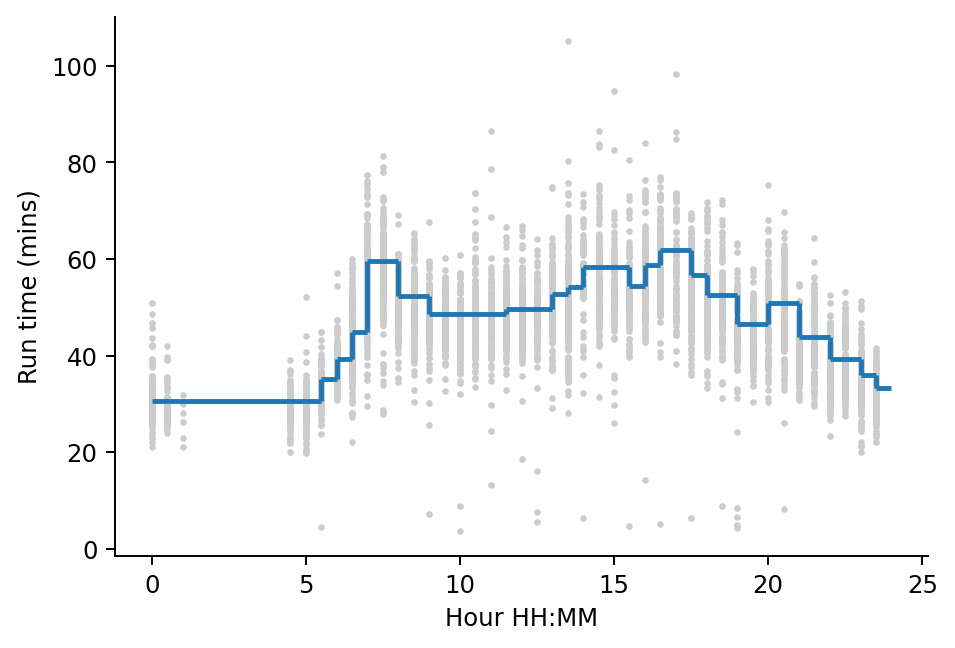

In [29]:
fig, ax = plt.subplots(figsize=(6,4), dpi=175)
plt.scatter(df2['bin']/2,df2['runtime'],color='.8',s=3)
for i in opt.index:
    y = opt.at[i, 'sched_run']
    x0, x1 = opt.at[i, 'start_time'], opt.at[i, 'end_time']
    # horizontal line
    ax.hlines(y, x0, x1, linewidth=2, color='tab:blue')
    # vertical connector to next segment
    if i < opt.index.max():
        y_next = opt.at[i+1, 'sched_run']
        ax.vlines(x1, y, y_next, linewidth=2, color='tab:blue')

plt.xlabel('Hour HH:MM')
plt.ylabel('Run time (mins)')
sns.despine()
plt.savefig('pm')